# Random Forest Vs ResNet50 on American Sign Language Image Recognition

## Contibutions
Paulo McKone - Random Forest for ASL image processing, project setup and initial data collection, final report

Samuel Huestis - ResNet50 for ASL image processing, supplemental data collection, final report

# Overview

This Machine Learning Project is focused on classifying American Sign Language (ASL) hand sign. Specifically only the hands signs that represent the letters of the alphabet. The hand signs are represented using images that are retrieved from Kaggle.

Aside from just classifying the hand signs, this project uses two distinct models to determine if neural networks or ensemble models are more accurate at classifying the hand signs. The two models being Random Forest(ensemble of decision trees) and ResNet50(neural network). We wanted to see if neural networks would out perform a more traditional model in image classification.

**Note: GPU should be on if running this in Colab to allow ResNet50 to run faster.**

In [1]:
!pip install kagglehub

## **Important: You may need to restart the session or be asked to restart the session due to imports**

In [2]:
!pip install "numpy<2" pandas opencv-python mediapipe

In [3]:
import kagglehub
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
import string
# path = kagglehub.dataset_download("danrasband/asl-alphabet-test")
path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)

# root = os.path.join(path, "asl_dataset/asl_alphabet_train")
root = os.path.join(path, "asl_alphabet_train/asl_alphabet_train")
print("Using dataset root:", root)

print("Root path:", root)
print("\nFolders inside dataset:")
print(os.listdir(root))

letters_only = [folder for folder in os.listdir(root) if folder in string.ascii_uppercase]

print("\nLetters only folders inside dataset:")
print(letters_only)

Using Colab cache for faster access to the 'asl-alphabet' dataset.
Path to dataset files: /kaggle/input/asl-alphabet
Using dataset root: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train
Root path: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train

Folders inside dataset:
['N', 'R', 'space', 'B', 'I', 'del', 'F', 'H', 'E', 'U', 'M', 'X', 'K', 'Q', 'Y', 'S', 'G', 'A', 'O', 'T', 'V', 'Z', 'C', 'P', 'L', 'W', 'D', 'nothing', 'J']

Letters only folders inside dataset:
['N', 'R', 'B', 'I', 'F', 'H', 'E', 'U', 'M', 'X', 'K', 'Q', 'Y', 'S', 'G', 'A', 'O', 'T', 'V', 'Z', 'C', 'P', 'L', 'W', 'D', 'J']


**DATA COLLECTION/IMPORTING**

We explored a variety of datasets from Kaggle but found that the data size was too little for the ResNet50 to produce meaningful results. There wasn't a good middle ground in regards for the comparison there for we decided that the best thing to do is use a large dataset to satisfy the resnet50 while normalizing the data for the random forest to make it more accurate of a comparison and to lessen the chance of overfitting.

**Displaying Dataset**


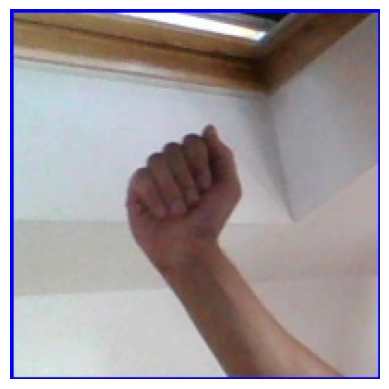

In [4]:
class_folder = os.path.join(root, "A")
# print(class_folder)
# Pick the first image
img_path = os.path.join(class_folder, os.listdir(class_folder)[0])

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.show()


**Pre-processing (labeling images)**

Each folder is labeled, which is the basis for the label of each image below.

In [5]:
IMG_SIZE = 64

X = []
y = []

for label in os.listdir(root):
    class_folder = os.path.join(root, label)

    if label not in string.ascii_uppercase:
      continue

    if not os.path.isdir(class_folder):
        continue

    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)

        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        X.append(img.flatten())
        y.append(label)
X = np.array(X)
y = np.array(y)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

Feature matrix shape: (78000, 4096)
Labels shape: (78000,)


**RandomForest configuration and processing**

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import joblib

n_trees = 20          # total trees you want
trees_step = 5        # save/evaluate every 5 trees

cv_means = []
cv_stds = []
tree_counts = []

for t in range(trees_step, n_trees + 1, trees_step):
    print(f"Training Random Forest with {t} trees...")

    rfc = RandomForestClassifier(
        n_estimators=t,
        max_depth=25,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    )

    scores = cross_val_score(rfc, X, y, cv=5, n_jobs=-1)

    print(f"Checkpoint {t} trees → Accuracy: {scores.mean():.4f}")

    cv_means.append(scores.mean())
    cv_stds.append(scores.std())
    tree_counts.append(t)

    joblib.dump(rfc, f"rf_checkpoint_{t}_trees.pkl")

print("Done.")


Training Random Forest with 5 trees...
Checkpoint 5 trees → Accuracy: 0.9559
Training Random Forest with 10 trees...
Checkpoint 10 trees → Accuracy: 0.9755
Training Random Forest with 15 trees...
Checkpoint 15 trees → Accuracy: 0.9811
Training Random Forest with 20 trees...
Checkpoint 20 trees → Accuracy: 0.9845
Done.


**Plotting the results of Random Forest on the ASL dataset**

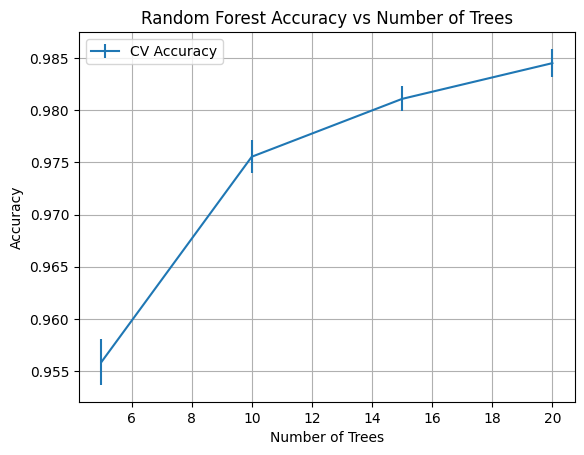

In [7]:
plt.errorbar(tree_counts, cv_means, yerr=cv_stds, label="CV Accuracy")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.title("Random Forest Accuracy vs Number of Trees")
plt.grid(True)
plt.legend()
plt.show()


# ResNet50

ResNet50 is a powerful convolutional neural network (CNN) that is commonly used for processing images. It apart of the ResNet (Residual Network) family and is made up of 50 layers that enable it to learn deeply. Being that it is apart of the ResNet architecture, it is able to learn deeper then previous models who encountered vanishing gradients. Essentially meaning that because gradients are interconnected, as you calculate the derivates of each gradient, the derivative values lead to smaller gradients. ResNet architecture introduced skip connections to solve this issue. By using the residual mapping or the difference between the input and outputs, ResNet is able to mitigate the vanishing gradient problem.

**ResNet50 configuration and processing**

For the processing of ResNet50, we start by fitting the images and reshaping them. To be consistent with both models, we are using 64 by 64 image sizes. Additionally we are using grayscale in ResNet to be consistent with Random Forest. Generally, ResNet50 expects the data as 224 by 224 and RGB coloring.

In a real worked scenario, ResNet50 would be trained using the "iamgenet" weights. This pretrained data give ResNet50 a big advantage and would have changed how much data we would have needed to train ResNet50. To focus on the comparison of the models themselves, we wanted to use no weights with ResNet50.


In [30]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

if tf.config.list_physical_devices('GPU'):
  device = "GPU"
else:
  device = "CPU"

print(f"Using {device} device")

# 1 Channel because we are using greyscale
# ResNet50 expects image size 224, 224, but using 64 for consitency and speed to train
IMAGE_SIZE = [64, 64, 1]
PIXEL = 64

X_shaped = X.reshape(-1,PIXEL,PIXEL,1)/255

encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(np.array(y).reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X_shaped, y_encoded, test_size=.2, random_state=42)

# Number of Passes
EPOCHS = 20

input = Input(shape=IMAGE_SIZE)

# No weights means no pretrained data
base_ResNet = ResNet50(weights=None, include_top=False, input_shape=IMAGE_SIZE, input_tensor=input)

# Uncomment to see training model details
# print(base_ResNet.summary())

X_RN = base_ResNet.output
X_RN = GlobalAveragePooling2D()(X_RN)
X_RN = Flatten()(X_RN)

predictions = Dense(26, activation='softmax')(X_RN)
model = Model(inputs=base_ResNet.input, outputs=predictions)

# Adam helps to control the learning process
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_split=0.2)

result = model.evaluate(X_test, y_test)
loss = str(result[0])
accuracy = str(result[1])

print ("Loss = " + loss)
print ("Test Accuracy = " + accuracy)

Using GPU device
Epoch 1/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 135s 58ms/step - accuracy: 0.3209 - loss: 2.2692 - val_accuracy: 0.6746 - val_loss: 0.8781
Epoch 2/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 86s 55ms/step - accuracy: 0.8107 - loss: 0.5346 - val_accuracy: 0.8535 - val_loss: 0.4499
Epoch 3/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 86s 55ms/step - accuracy: 0.9112 - loss: 0.2591 - val_accuracy: 0.9078 - val_loss: 0.2627
Epoch 4/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 87s 55ms/step - accuracy: 0.9462 - loss: 0.1596 - val_accuracy: 0.9192 - val_loss: 0.2485
Epoch 5/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 87s 56ms/step - accuracy: 0.9605 - loss: 0.1158 - val_accuracy: 0.9444 - val_loss: 0.1624
Epoch 6/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 87s 56ms/step - accuracy: 0.9759 - loss: 0.0775 - val_accuracy: 0.9643 - val_loss: 0.1103
Epoch 7/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 87s 56ms/step - accuracy: 0.9795 - loss: 0.0650 - val_accuracy: 0.8539 - val_loss: 0.8674
Epoch 8/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 86s 55ms/step - 

**Plotting the results of ResNet50 on the ASL dataset**

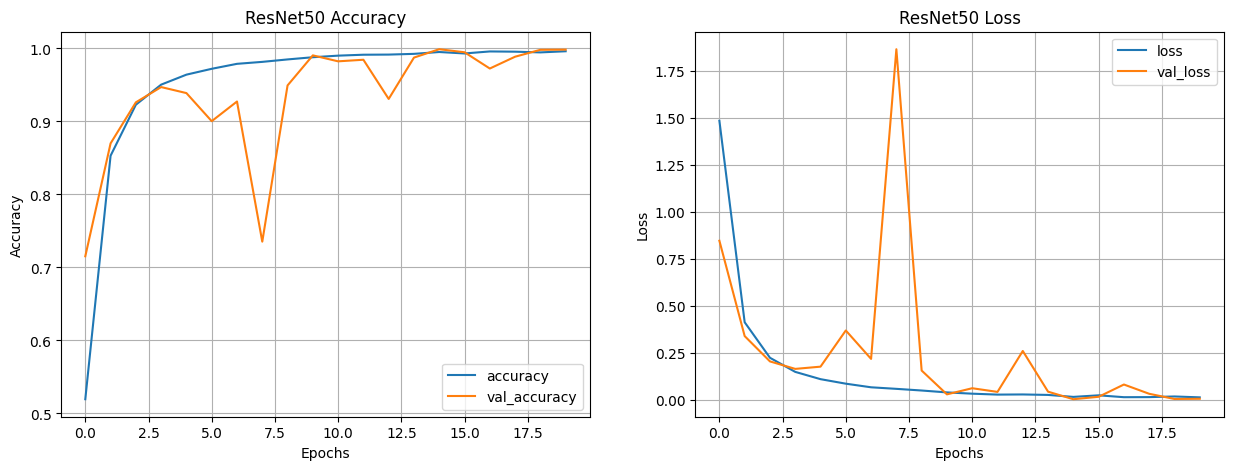

In [29]:
fig, (first, second) = plt.subplots(1, 2, figsize=(15, 5))

first.plot(history.history['accuracy'], label='accuracy')
first.plot(history.history['val_accuracy'], label='val_accuracy')
first.grid(True)
first.set_title('ResNet50 Accuracy')
first.set_ylabel('Accuracy')
first.set_xlabel('Epochs')
first.legend()


second.plot(history.history['loss'], label='loss')
second.plot(history.history['val_loss'], label='val_loss')
second.grid(True)
second.set_title('ResNet50 Loss')
second.set_ylabel('Loss')
second.set_xlabel('Epochs')
second.legend()

plt.show()

# ResNet50 Graph Discussion

Based on the two graphs above, we can see that the is one large spike in the loss of the model. This Loss indicated that the model is overfitting and is memorizing the data it is given. This spike quickly resolves itself though and the loss closes its distance towards the end of the Epochs. This is a good indication that our ResNet50 has actually learned the data and has also achieved very high accuracy in classifying the data that its is given.

# Random Forest Vs ResNet50 Conclusions

Both the Random Forest model and the ResNet50 model finished with high accuracies. While the ResNet50 did slightly outperform the Random Forest model, the gap between accuracies is low (~ .5% to 1%).

Since both models had a similar final accuracy, looking at the time to train each model, it is clear to say that the Random Forest is more efficient to train than the ResNet50 model. The Random Forest model only took about a minute to train while the ResNet50 model with 20 Epochs takes around 30 minutes to train (using T4 High RAM GPU in Colab).

In addition to high hardware resource consumption, ResNet50 also requires a lot of data when training without weights. Before switching datasets, we had around 30 images per hand sign. With this limited amount of data, ResNet50 produced very low accuracies, even with relatively high epochs.

So for the particular use case of identifying American Sign Language hand signs using images, if resources and time are a factor, the winner would be Random Forest. Simply because it can get the similar accuracies with a fraction of the time and resources as ResNet50. If the goal is the highest accuracies possible, then ResNet50 would be a better fit.

**Reasources and Sources**

For general understanding of ResNet arguments to use: https://keras.io/api/applications/resnet/

Understanding Adam Optimizer: https://www.geeksforgeeks.org/deep-learning/adam-optimizer/


https://www.geeksforgeeks.org/dsa/random-forest-classifier-using-scikit-learn/

General help understanding ResNet50: https://www.geeksforgeeks.org/computer-vision/image-classification-using-resnet/

Tutorial of using ResNet50 for detecting aliens and preditors as images: https://www.youtube.com/watch?v=5SJAPmQy7xs&t=2s

Example processing with ResNet50: https://github.com/priya-dwivedi/Deep-Learning/blob/35a3ea2842eaa4a194a19f95436294a0a38cdc72/resnet_keras/Residual_Network_Keras.ipynb#L86

For understanding how ResNet50 solved the vanashing gradient problem: https://medium.com/@sandushiw98/understanding-resnet-50-solving-the-vanishing-gradient-problem-with-skip-connections-5591fcb7ff74